#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
# Testing if integration works

In [2]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [3]:
file_name = '/home/s2287251/idcom_imaging/data/fastMRI/knee/shuffle_gt/file1000220.h5'
hf = h5py.File(file_name)

In [4]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
print('reconstruction_esc', hf['reconstruction_esc'][()].shape)

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00024442943829965905, 'norm': 0.06645007571317302, 'patient_id': '9c0b8c67ca4043b3cd63f38b843f4ea90f71a1a43de57cca84ccb0e530f72f31'}
reconstruction_esc (40, 320, 320)


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [11]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)
volume_target = hf['reconstruction_esc'][()]

complex64
(40, 640, 368)


Let's see what the absolute value of k-space looks like:

In [12]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

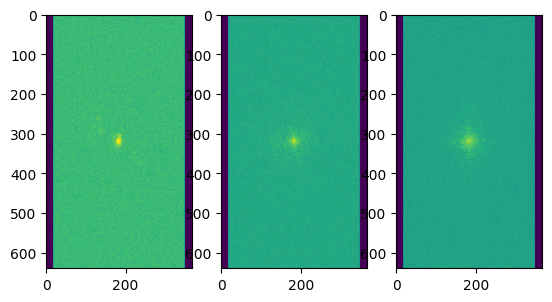

In [13]:
show_coils(np.log(np.abs(volume_kspace) + 1e-9), [0, 5, 10]) 

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [9]:
import fastmri
from fastmri.data import transforms as T

In [14]:
slice_kspace2 = T.to_tensor(volume_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

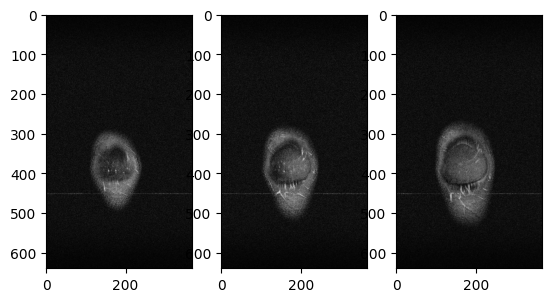

In [22]:
show_coils(slice_image_abs, [3, 4, 5], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

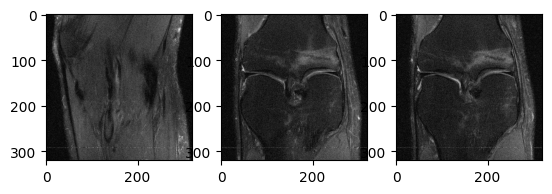

In [23]:
show_coils(volume_target, [3, 4, 5], cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [ ]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [ ]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [ ]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

In [ ]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')